In [1]:
# %matplotlib inline
%matplotlib notebook
import numpy as np
import pandas as pd
from pandas import DataFrame as DF
from collections import OrderedDict as OD
import math
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import os

In [2]:
# Set plot defaults:
mpl.rcParams['figure.figsize'] = [8.0, 5.0]
savefigw = 11.2
savefigh = 7.
mpl.rcParams['font.size'] = 13
mpl.rcParams['lines.linewidth'] = 3
# mpl.rcParams['legend.fontsize'] = 'small'

plt.rcParams["text.usetex"] = False

# mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titleweight'] = 'normal'
mpl.rcParams['axes.labelsize'] = 20
# mpl.rcParams['axes.labelweight'] = 'heavy'

mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['xtick.major.size'] = 6.5
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.minor.size'] = 4.0
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['ytick.major.size'] = 6.5
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.minor.size'] = 4.0


In [ ]:
mpl.rcParams.keys()

In [3]:
datadir = '/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/plotsdata/Glue'
plotdir = '/Users/troyraen/Documents/Talks/WIMP_Paper'
fzams = datadir+ '/zams.csv'
fdesc = datadir+ '/descDF_MS_allmassesreg.csv'

# Helper Fncs

In [4]:
# Cboost colormap and colorbar

# used in plt.plot and other places to normalize colorbar
vmin=-0.5
vmax=6.5

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """ Returns a new color map, trucated at min/maxval."""
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def get_cmap_color(val, cmap=None):
    """ Returns rgba color of val in cmap normalized to global vmin, vmax"""
    if cmap==None:
        cmap = cbcmap
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    rgba = cmap(norm(val))
    return rgba

def get_cmapdict(cb,l):
    """ Returns a dict to be used as kwargs in plt.plot.
        all get the same color (specific cb)
    """
    return {'c':cb*np.ones(l), 'cmap':cbcmap, 'vmin':vmin, 'vmax':vmax}

def get_cbcbar(sm=None, **kwargs):
    """ Returns a colorbar that will be added to the side of a plot.
        Intended to be used with plotting that uses cbcmap as the colormap.
    """
    cbar = plt.colorbar(sm, **{'pad':0.01}, **kwargs)
    cbar.set_ticks([0,1,2,3,4,5,6],update_ticks=False)
    cbar.set_ticklabels(['NoDM',r'$10^1$',r'$10^2$',r'$10^3$',r'$10^4$',r'$10^5$',r'$10^6$'])
    cbar.ax.minorticks_off()
    cbar.set_label(r'$\Gamma_B$', labelpad=-5)
    return cbar

# Create cboost colormap (cbcmap):
cmapinf = plt.get_cmap('inferno_r')
cmapinftrunc = truncate_colormap(cmapinf, 0.2, 0.8)
cmapblues = plt.get_cmap('Blues')
c0c = get_cmap_color(0, cmap=cmapinftrunc)
c1c = get_cmap_color(1, cmap=cmapinftrunc)
c2c = get_cmap_color(2, cmap=cmapinftrunc)
c3c = get_cmap_color(3, cmap=cmapblues)
c4c = get_cmap_color(5, cmap=cmapblues)
c5c = get_cmap_color(4, cmap=cmapinftrunc)
c6c = get_cmap_color(6, cmap=cmapinftrunc)
carr = (c0c,c1c,c2c,c3c,c4c,c5c,c6c)
cbcmap = ListedColormap(carr)

In [5]:
def fix_desc_mass(df):
    descdf['mass'] = descdf.apply(get_mass_from_idx, axis=1)
    return df

    
def get_mass_from_idx(row):
    #     get star id
    idx = int(row['star_index'])
#     print('\nindex {0}, start mass {1}'.format(idx, row['mass']))

    #     parse to get mass
    mint = str(idx)[:-3]
    if int(mint[0])>5 or len(mint)==1:
        mass = float('0.'+mint)
    else:
        mass = float(mint[0]+'.'+mint[1:])
#     print('\tnew mass {}'.format(mass))
    return mass

In [ ]:
# NOT USING
# Function taken from
# https://stackoverflow.com/questions/19522004/building-a-dictionary-from-directory-structure
import sys
import os
from stat import *


def PathToDict(path):
    st = os.stat(path)
    result = {}
    result['active'] = True
    #result['stat'] = st
    result['full_path'] = path
    if S_ISDIR(st.st_mode):
        result['type'] = 'd'
        result['items'] = {
            name : PathToDict(path+'/'+name)
            for name in os.listdir(path)}
    else:
        result['type'] = 'f'
    return result

### Profiles

In [6]:
profiles_datadir = '/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/'

In [7]:
def get_pidx(cb, modnum, mass=3.5):
    return 'm{mass}c{cb}mod{modnum}'.format(mass=mass, cb=cb, modnum=modnum)

def get_profile_path(row):
    """ row should be a row from df pidxdf.
        Returns path to the profile#.data file"""
    path = row.path_to_LOGS
    pnum = row.profile_number
    fprof = path+ '/profile'+ str(pnum)+ '.data'
    return fprof

In [8]:
def get_profilesindex_df(profile_runs_dir=profiles_datadir):
    """ Returns a df of all profiles.index files in path profile_runs_dir.
            Columns are { mass, cb, path_to_LOGS, priority, model_number, profile_number }
        Assumes particular path structure, 
            as written by mesa_wimps script ./bash_scripts/profile_run.sh
    """
    pidx_cols = ['model_number', 'priority', 'profile_number']
    
    dflist = []
    for cb in os.listdir(profile_runs_dir):
        cbpath = profile_runs_dir+ cb
        for mass in os.listdir(cbpath):
            Lpath = cbpath+'/'+ mass+'/'+'LOGS'
            fpidx = Lpath+ '/profiles.index'
            try:
                df = pd.read_csv(fpidx, names=pidx_cols, skiprows=1, header=None, sep='\s+')
            except:
                print('{} does not exist.'.format(fpidx))
                continue

#             add mass, cb, and path
            tmp = mass.split('_', maxsplit=1)[0][1:]
            mass_float = float(tmp[0]+'.'+tmp[2:])
            df['mass'] = mass_float
            df['cb'] = int(cb[1])
            df['path_to_LOGS'] = Lpath
            
            dflist.append(df)

    return pd.concat(dflist, ignore_index=True)

pidxdfOG = get_profilesindex_df()

/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/c0/m1p00_stopmod1/LOGS/profiles.index does not exist.
/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/c6/m1p00_stopmod1/LOGS/profiles.index does not exist.
/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/c3/m1p00_stopmod1/LOGS/profiles.index does not exist.


In [9]:
def get_meta_df(pidxdf=None):
    """ Returns df of metadata of all profiles in pidxdf
        Looks up path to files in pidxdf (as returned by get_profilesindex_df().
    """
#     Get correct rows from pidxdf
    try:
        p = pidxdf if pidxdf is not None else pidxdfOG
        assert type(p)==pd.DataFrame
        
    except:
        print('Getting get_profilesindex_df()...')
        p = get_profilesindex_df()
        
        
    dflist = []
    # Get the metadata:
    for i, row in p.iterrows():
        fprof = get_profile_path(row)
        try:
            metadf = pd.read_csv(fprof, header=1, sep='\s+', nrows=1)
        except:
            print(fprof, 'metadata cannot be loaded')
            
        idx = get_pidx(row.cb, row.model_number)
        metadf['pidx'] = str(idx)
        metadf['cb'] = row.cb
        metadf['path'] = fprof

        dflist.append(metadf)
#         break

    df = pd.concat(dflist, ignore_index=True)
    df.set_index('pidx', inplace=True, drop=False)
    return df

        
mdf = get_meta_df()

In [146]:
def load_prof_from_file(cb, modnum, mass=3.5, pidxdf=None):
    """ Returns profile index and 2 dfs (df and metadf) from profile#.data info.
        Looks up path to file in pidxdf (as returned by get_profilesindex_df().
    """
#     Get correct rows from pidxdf
    try:
        p = pidxdf if pidxdf is not None else pidxdfOG
        assert type(p)==pd.DataFrame
        
    except:
        print('Getting get_profilesindex_df()...')
        p = get_profilesindex_df()
    req = p.loc[(p.mass==mass) & (p.cb==cb) & (p.model_number==modnum)] # df with rows matching input
    if len(req)>1:
        print('Found {n} rows matching input m{mass} c{cb} mod{mod}. Paths are: \
                \n{path}\n\nUsing the last.'
              .format(n=len(req), mass=mass, cb=cb, mod=modnum, path=req.path_to_LOGS.values))
    
#     Load data and meta_data to dfs
    try:
        row = req.iloc[-1]
        fprof = get_profile_path(row) # Get path to profile#.data

        df = pd.read_csv(fprof, header=4, sep='\s+')
        df['path'] = fprof
        metadf = pd.read_csv(fprof, header=1, sep='\s+', nrows=1)
        metadf['path'] = fprof
    except:
        print('Profile for m{mass}, c{cb}, mod{mod} does not seem to exist.'.format(
                                                        mass=mass, cb=cb, mod=modnum))
        
    idx = get_pidx(cb, modnum, mass=mass)

    return [idx, df, metadf]


In [11]:
# dictionary of loaded profile#.data dfs
pdfs = {}
# main key: profile index as returned by load_prof_from_file
# main value: dict with keys/values: idx, df, metadf

def get_pdf(cb, modnum, mass=3.5, rtrn='df'):
    """ Returns profile#.data as df. Loads from file if needed.
        rtrn =  'metadf' returns the metadf
                'idx' returns the profile index
                'all' returns all three as a list
    """
    pidx = get_pidx(cb, modnum, mass=mass)
    try:
        idx = pdfs[pidx]['idx']
        df = pdfs[pidx]['df']
        metadf = pdfs[pidx]['metadf']
    except:
        idx, df, metadf = load_prof_from_file(cb, modnum, mass=mass) # load from file
        pdfs[idx] = {} # save to dict
        pdfs[idx]['df'] = df
        pdfs[idx]['metadf'] = metadf
    
    if rtrn == 'df':
        return df
    if rtrn == 'metadf':
        return metadf
    if rtrn == 'idx':
        return idx
    if rtrn == 'all':
        return [idx, df, metadf]

In [12]:
def get_h1_modnums(frm='profile_metadata', mass=3.5, hdf=None, cb=None):
    """ Returns dict, key = cb, val = list of model numbers corresponding to 
                                        center_h1 cuts in dict h1cuts = get_h1cuts()
        frm = 'profile_metadata' uses mdf for look up
        frm = 'history_data' uses a history df (must pass hdf and cb)
    """
    h1cuts = get_h1cuts()
    cbmods = {} # dict of lists of model numbers

    if frm == 'history_data':
        mods = []
        for name, h1c in h1cuts.items():
            try:
                # Get the first model number after center_h1 < h1c:
                tmp = hdf[hdf.center_h1<h1c].sort_values('model_number').model_number
                mods.append(tmp.iloc[0])
            except IndexError:
                print()
                print(name, 'no model with center_h1 < ', h1c)
                print('setting modnum to NaN')
                mods.append(float('NaN'))
            except:
                print()
                print('Make sure you passed a valid hdf to get_h1_modnums.')
        cbmods[cb] = mods
                
    
    elif frm == 'profile_metadata':
        cbg = mdf[mdf.initial_mass==mass].groupby('cb', sort=True) # ensure sorted by cb value
        for i, (cb, df) in enumerate(cbg):
            mods = [] # list of model numbers
            for name, h1c in h1cuts.items():
                try:
                    # Get the first model number after center_h1 < h1c:
                    tmp = df[df.center_h1<h1c].sort_values('model_number').model_number
                    mods.append(tmp.iloc[0])
                except IndexError:
                    print()
                    print(cb, name, 'no model with center_h1 < ', h1c)
                    print('setting modnum to NaN')
                    mods.append(float('NaN'))

            cbmods[cb] = mods
    else:
        print('Must pass valid argument with frm. (profile_metadata or history_data)')

    return cbmods


def get_h1cuts():
    """ Returns OD of h1 cuts to find profile model numbers"""
    start_center_h1 = 0.718 # this is the same for all models

    # define h1 cuts to find profile model numbers
    # taken from Dotter where possible
    h1cuts = OD([('ZAMS',start_center_h1 - 0.0015), 
                 ('IAMS',0.3), 
                 ('H-1',1e-1), 
                 ('H-2',1e-2), 
                 ('H-3',1e-3), 
                 ('H-4',1e-4), 
                 ('H-6',1e-6), 
                 ('TAMS',1e-12)])

    return h1cuts

### History

In [13]:
def get_hidx(cb,mass=1.0):
    return 'm{mass}c{cb}'.format(mass=mass, cb=cb)


def load_hist_from_file(cb, mass=1.0, pidxdf=None):
    """ Returns df of history.data from LOGS dir of 
            highest model number matching cb, mass (to get most copmlete data).
            
        Send pidxdf = [] (or other type) to force it to reload from disk
    """
    # Get pidxdf
    try:
        p = pidxdf if pidxdf is not None else pidxdfOG
        assert type(p)==pd.DataFrame
    except:
        print('Getting get_profilesindex_df()...')
        p = get_profilesindex_df()
        
    # Get path to LOGS dir
    try:
        mcb_mods = p[(p.mass==mass) & (p.cb==cb)][['model_number','path_to_LOGS']]
        Lpath = mcb_mods.sort_values('model_number').iloc[-1].path_to_LOGS
    except:
        print('No models matching m{mass} c{cb} in pidxdf'.format(mass=mass, cb=cb))

    # Load history.data
    try:
        hpath = Lpath+ '/history.data'
        df = pd.read_csv(hpath, header=4, sep='\s+')
    except:
        print(hpath, 'not loaded')

    return df

In [14]:
hdfs = {} # holds loaded history dataframes
def get_hdf(cb, mass=1.0, from_file=False):
    """ Returns history.data file as df from loaded dict.
        Loads data from file if necessary, getting the file
            with the largest model number in pidxdf.
                
        from_file == True forces reload from disk.
    """
    
    hidx = get_hidx(cb, mass=mass)
    try:
        hdf = hdfs[hidx]
        if from_file == True:
            hdf = [] # change type to force reload from file
        assert type(hdf) == pd.DataFrame
    except:
        print('loading {} history df from file'.format(hidx))
        hdf = load_hist_from_file(cb, mass=mass, pidxdf=[])
        hdf['cb'] = cb
        hdf['hidx'] = hidx
        hdf.set_index('hidx', drop=False, inplace=True)
        hdfs[hidx] = hdf
        
    return hdf
    

### Plots

In [15]:
def get_xfrac_lbl(pdf):
    # get h1_center from profile df to use as plot label to check closeness to PEEP definition
    xfrac = pdf[pdf.q == min(pdf.q)].x.iloc[0]
    if xfrac>1e-3:
        xfrac_lbl = r'$h1_c$ = ' + str(np.round(xfrac,4))
    else:
        xfrac_lbl = r'log($h1_c$) = ' + str(np.round(np.log10(xfrac),3))

    return xfrac_lbl

# 1.0 Msun

### Main data structures are:
pidxdfOG = get_profilesindex_df() = df of all profiles.index files
                with cols { mass, cb, path_to_LOGS, priority, model_number, profile_number }

mdf = get_meta_df() = df of all metadata in profile#.data files

pdf = get_pdf(cb, modnum, mass=3.5) = df of data from specific profile#.data file

metadf = get_pdf(cb, modnum, mass=3.5, rtrn='metadf') = df of metadata from specific profile#.data file

hdf = get_hdf(cb, mass=1.0) = df of history file

In [16]:
# GET H1cuts MODEL NUMBERS FROM HISTORY FILE
    # SO THAT I CAN SAVE THE CORRECT PROFILES.

pidxdfOG = get_profilesindex_df()

# hdf = get_hdf(0, mass=1.0)
# get_h1_modnums(frm='history_data', mass=1.0, hdf=hdf, cb=0)

# hdf = get_hdf(3, mass=1.0)
# get_h1_modnums(frm='history_data', mass=1.0, hdf=hdf, cb=3)

hdf = get_hdf(6, mass=1.0)
get_h1_modnums(frm='history_data', mass=1.0, hdf=hdf, cb=6)


/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/c0/m1p00_stopmod1/LOGS/profiles.index does not exist.
/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/c6/m1p00_stopmod1/LOGS/profiles.index does not exist.
/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/c3/m1p00_stopmod1/LOGS/profiles.index does not exist.
loading m1.0c6 history df from file
Getting get_profilesindex_df()...
/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/c0/m1p00_stopmod1/LOGS/profiles.index does not exist.
/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/c6/m1p00_stopmod1/LOGS/profiles.index does not exist.
/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/c3/m1p00_stopmod1/LOGS/profiles.index does not exist.

H-1 no model with center_h1 <  0.1
setting modnum to NaN

H-2 no model with center_h1 <  0.01
setting modnum to NaN

H-3 no model with center_h1 <  0.001
setting modnum to NaN

H-4 no model with center_h1 <  0.0001
setting modnum to 

{6: [706, 1957, nan, nan, nan, nan, nan, nan]}

In [ ]:
get_h1cuts()

In [24]:
def get_burn_cols(hdf):
    """ Returns df with cols {star_age, burn_type, mass_top, mass_bottom}
                where mass_ is mass coord in [Msun] (converts q to mass(<r)).
        Ensures burn zone matches burn type.
        """
#     concat burn columns, check that have 1 time step for every burn type

    hdf.set_index('star_age', inplace=True, drop=False)
    
    btcols = sorted([ col for col in hdf.columns if 'burn_type' in col ])
    bqtcols = sorted([ col for col in hdf.columns if 'burn_qtop' in col ])
    dflist = []
    for i in range(len(btcols)):
        bt_name = btcols[i]
        bqt_name = bqtcols[i]

        bt = hdf[bt_name]
        ages = hdf.star_age
        
        # get burn zone coords
        burn_qtop = hdf[bqt_name]
        if i == 0:
            burn_qbottom = 0*burn_qtop
        else:
            burn_qbottom = hdf[bqtcols[i-1]]
        # convert to Msun
        mass_top = burn_qtop*hdf.star_mass
        mass_bottom = burn_qbottom*hdf.star_mass
        
        col_list = OD([('star_age',ages), ('burn_type',bt), 
                       ('mass_top',mass_top), ('mass_bottom',mass_bottom)])
#         print([col_list[i].sample() for i in range(len(cols))])
        tmp = pd.DataFrame(col_list)
#         tmp.columns = cols

        
        dflist.append(tmp)
        
                     
    df = pd.concat(dflist, axis=0)
    df = df[df.burn_type != -9999]
#     print(btcols)
#     'burn_type_1', 'burn_qtop_1'
    return df


# ### NOT CURRENTLY USING
from scipy import interpolate as interp
def interp_burn_cols(df, xlim):
    """ Returns dataframe interpolated from df
    """
    sa = df.star_age.values
    ages = np.linspace(xlim[0], xlim[1], int(1e6))
    fb = interp.interp1d(sa,df.mass_bottom)
    ft = interp.interp1d(sa,df.mass_top)

    icols = OD([ ('star_age',ages), 
                ('mass_bottom', fb(ages)), ('mass_top',ft(ages)) ])
    idf = pd.DataFrame(icols)

    return idf

In [123]:

def plot_m1p0c6_age(plot_times=None, from_file=False, save=None):
    """ Gets and plots the history.data file """

    if plot_times is None:
        plot_times = list(get_osc_modnums().keys())
    ntimes = len(plot_times)

    xlim = (1.9*10**8, 4.*10**8)
    ylim = (0.,0.7)
    ylimtwin = (-0.7, 0.5)
    cb = 6
    burn_zone_colors = ['w', 'darkorange','darkred']
    
    hdf0 = get_hdf(0, mass=1.0, from_file=from_file)
    hdf = get_hdf(cb, mass=1.0, from_file=from_file)
    
    
    if save is None:
        plt.figure()
#         mnum=5e2
    else:
        plt.figure(figsize=(savefigw, savefigh))
#         mnum=1e4
    ax = plt.gca()
    axtwin = ax.twinx()

    
    # Plot burning:
    burn_cols0 = get_burn_cols(hdf0)
    bzones0 = burn_cols0.groupby('burn_type', sort=True)
    burn_cols = get_burn_cols(hdf)
    bzones = burn_cols.groupby('burn_type', sort=True)
    for b, (bz, cols) in enumerate(bzones):
        c = burn_zone_colors[bz]
        alph = 0.7
#         icols = interp_burn_cols(cols, xlim) # SLOW WITH MINIMAL EFFECT
        icols=cols
        ax.fill_between(icols.star_age, icols.mass_bottom, y2=icols.mass_top, 
                        step='mid', color=c, alpha=alph)
        cols0 = bzones0.get_group(bz).sort_values('star_age')
#         icols0 = interp_burn_cols(cols0)
        ax.plot(cols0.star_age, cols0.mass_top, color=c)
    
    
    # Plot osc times vlines:
    oscmods = get_osc_modnums() # dict
    om_names = list(get_osc_modnums().keys())
    # For osc times annotations:
    anny = ylim[1] - 0.05
    r = -90
    tdlta = 5e6
    fs = 10
    for t, tname in enumerate(om_names):
        if tname not in plot_times: continue
        tmod = oscmods[tname]
        tage = hdf[hdf.model_number==tmod].star_age.values[0]
        plt.axvline(tage, lw=0.5, c='k')
        # Osc times annotations:
        rot = -r if tname == 'Time5' else r
        td = 1.5*tdlta if tname=='Degen' else (0 if tname=='Time5' else tdlta)
        ax.annotate(tname,(tage-td,anny), rotation=rot, fontsize=fs)

    # Plot L
    Lc = 'b'
    axtwin.plot(hdf.star_age, hdf.log_L, color=Lc)
    axtwin.plot(hdf.star_age, hdf.log_LH, color=Lc, ls=':')
    axtwin.set_ylim(ylimtwin)
    axtwin.tick_params(axis='y', colors=Lc)
    axtwin.set_ylabel(r'log(L [L$_{\odot}$])', color=Lc)
    
    
    # Axes params:
    ax.semilogx()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(r'Star Age [yrs]')
    ax.set_ylabel(r'mass($<$r)')

    mpl.rcParams['xtick.direction'] = 'out'
    mpl.rcParams['ytick.direction'] = 'out'
    
    plt.tight_layout()
    if save is not None: plt.savefig(save)
    plt.show()

    



In [142]:
# give plot fnc list of model numbers
def get_osc_modnums():
    """ Returns OD of c6 model numbers to find profile model numbers.
        Times choosen by eye
        peeps given by:
            get_h1_modnums(frm='history_data', mass=1.0, hdf=get_hdf(6, mass=1.0), cb=6)
    """
    osc_modnums = OD([('Time1',1679), 
                 ('Time2',1720), 
                 ('Time3',1759),
                 ('Time4',1780),
                 ('Time5',1791),
#                  ('Degen',1915),
                 ('Degen',1909),
                 ('IAMS',1957), 
                 ('H-1',2001), 
                 ('H-2',2055), 
                 ('H-3',2086), 
                 ('H-4',2102), 
                 ('H-6',2253), 
                 ('TAMS',2321)])
    return osc_modnums

<IPython.core.display.Javascript object>


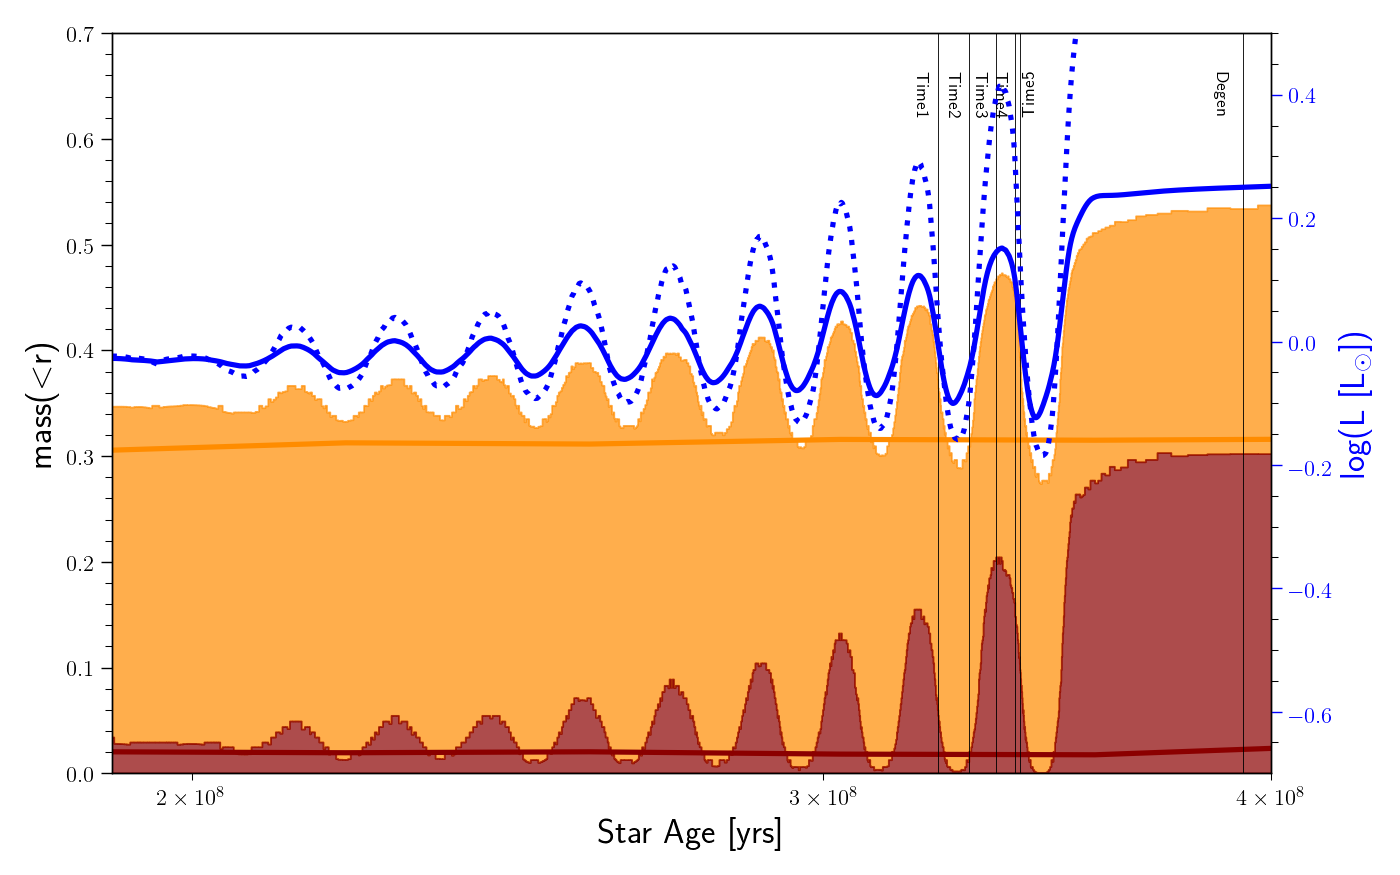

/Users/troyraen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: 'star_age' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


<IPython.core.display.Javascript object>


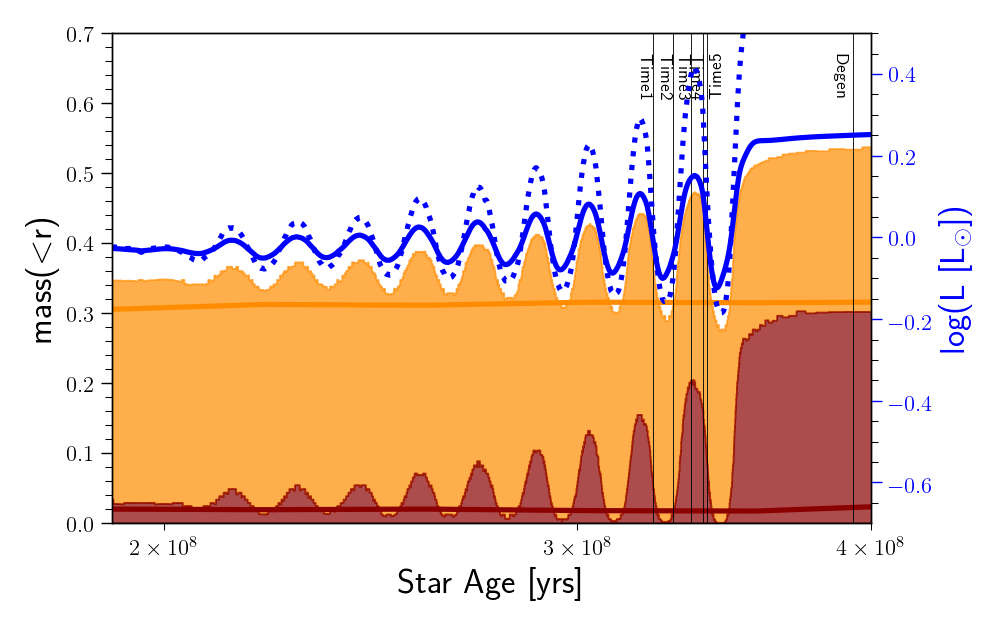

In [143]:
plt.rcParams["text.usetex"] = True
plot_times = [ 'Time1', 'Time2', 'Time3', 'Time4', 'Time5', 'Degen' ]

plot_m1p0c6_age(plot_times=plot_times, from_file=False, save=plotdir+ '/m1p0c6_age.png')
plot_m1p0c6_age(plot_times=plot_times, from_file=False)

In [152]:
cb=6
xmax=0.3
d = get_pdf(cb, get_osc_modnums()['Time3'], mass=1.0)
d = d[d.mass<xmax] # slice the portion that will be visible so axes scale correctly
d.eps_nuc_plus_nuc_neu


735     6.454233
736     6.672850
737     6.897855
738     7.129928
739     7.368957
740     7.615041
741     7.868541
742     8.130071
743     8.400524
744     8.680992
745     8.972419
746     9.275707
747     9.591549
748     9.920168
749    10.175056
750    10.436156
751    10.793755
752    11.067760
753    11.345463
754    11.719093
755    11.999660
756    12.279927
757    12.648877
758    13.009606
759    13.359454
760    13.613342
761    13.862626
762    14.184588
763    14.420384
764    14.655019
         ...    
774    18.599286
775    19.176021
776    19.779013
777    20.407828
778    21.062043
779    21.741324
780    22.445538
781    23.174767
782    23.929420
783    25.064515
784    26.731099
785    28.175758
786    29.014793
787    29.636646
788    30.039409
789    30.283088
790    30.456117
791    30.564054
792    30.630495
793    30.670537
794    30.693937
795    30.711485
796    30.729258
797    30.742946
798    30.751571
799    30.757006
800    30.760430
801    30.7625

/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/c0/m1p00_stopmod1/LOGS/profiles.index does not exist.
/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/c6/m1p00_stopmod1/LOGS/profiles.index does not exist.
/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/c3/m1p00_stopmod1/LOGS/profiles.index does not exist.


<IPython.core.display.Javascript object>


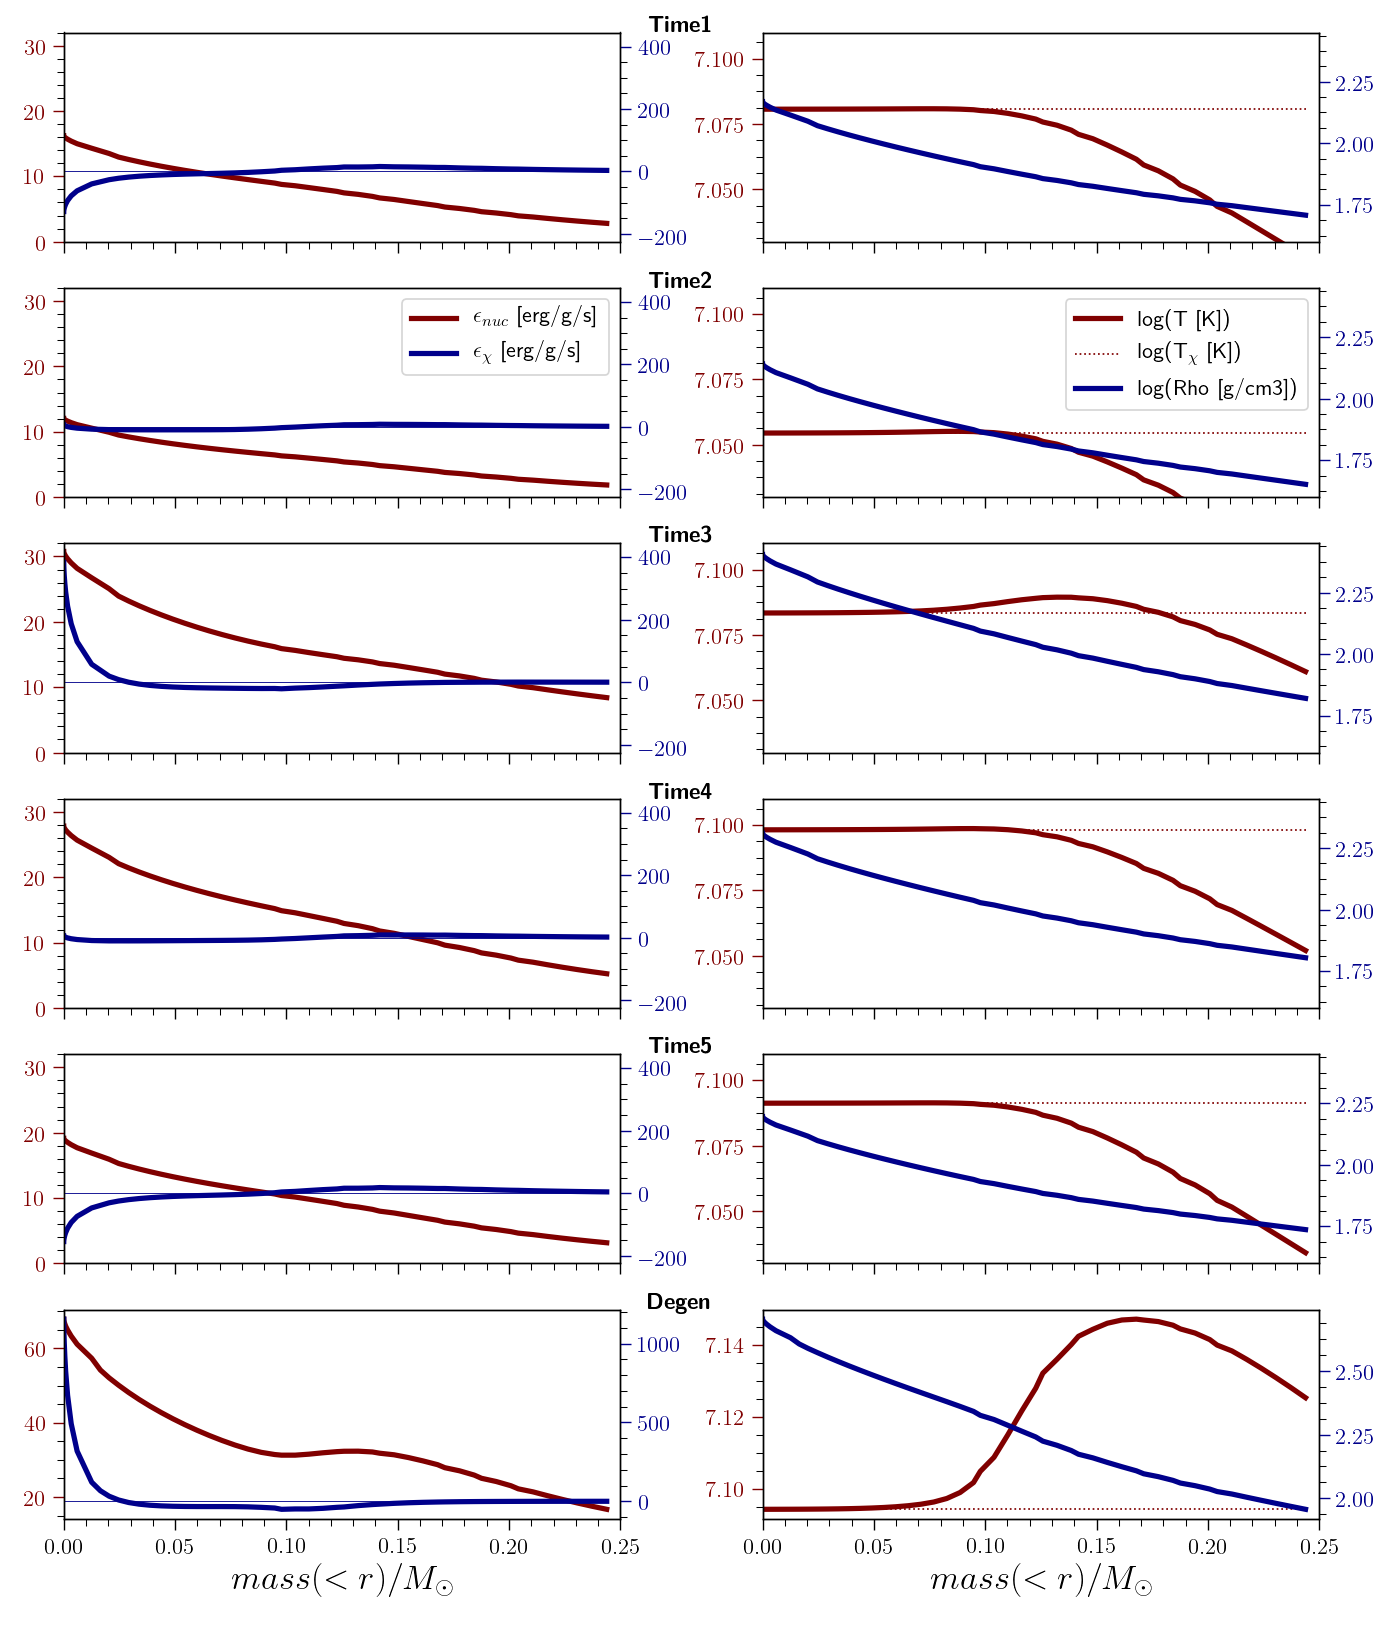

6 1679

6 1720

6 1759

6 1780

6 1791

6 1909



In [147]:
# MAKE m1p0c6 PLOT

pidxdfOG = get_profilesindex_df()

plt.rcParams["text.usetex"] = True
plot_times = [ 'Time1', 'Time2', 'Time3', 'Time4', 'Time5', 'Degen' ]

plot_m1p0c6(plot_times=plot_times, save=plotdir+ '/m1p0c6.png')

In [128]:
def plot_m1p0c6(plot_times=None, save=None):
    """ cbmods = ordered list of lists of model numbers to plot
            as returned by get_h1_modnums()
        plot_times = list of oscilation times (names defined in get_osc_modnums()) to plot
    """
    xmax = 0.25
    cb = 6
    
#     plot_times=None
    if plot_times is None:
        plot_times = list(get_osc_modnums().keys())
    ntimes = len(plot_times)
    
#     cbc = get_cmap_color(cb, cmap=cbcmap) # plot colors
    cl = 'maroon' # left axis color
    cr = 'darkblue' # right axis color
    
    # For annotations:
     # placement for extra heat arrows:
    delth = 0.015; deltv = 1.5
    l = 0.19; r = l + delth; b = 20; t = b + deltv
    xarws = [[(r,b),(l,t)], 
             [(r,b+10),(l,t+10)], 
             [(r,b+35),(l,t+35)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)]]
     # placement for nuclear burning arrows
    r = l; l = r - delth; b = 10; t = b + deltv
    narws = [[(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)]]

    ncols = 2
    if save is None:
        f, axs = plt.subplots(nrows=ntimes,ncols=ncols, sharex=True)
    else:
        f, axs = plt.subplots(nrows=ntimes,ncols=ncols, sharex=True, 
                                                          figsize=(savefigw, savefigh+6))
    axtwin = [ [axs[t,0].twinx() for t in range(ntimes)],
                [axs[t,1].twinx() for t in range(ntimes)] ]

    a = -1
    oscmods = get_osc_modnums() # dict
    om_names = list(get_osc_modnums().keys())
    for t, tname in enumerate(om_names):
        if tname not in plot_times:
            continue
        else:
            a = a+1
            
        print(cb, oscmods[tname])
        print()
        d = get_pdf(cb, oscmods[tname], mass=1.0)
        d = d[d.mass<xmax] # slice the portion that will be visible so axes scale correctly

        # Plot nuclear energy (use arrays to avoid auto generating legend label):
        axs[a,0].plot(np.array(d.mass), np.array(d.eps_nuc_plus_nuc_neu), c=cl)#, zorder=-i+6)

        # Plot Temperature:
        xfrac_lbl = get_xfrac_lbl(d)
#         tmtx = (10**d.logT - d.wimp_temp)/ 1e7
#         axs[a,1].plot(np.array(d.mass), np.array(tmtx), c=cbc)#, label=xfrac_lbl)
        axs[a,1].plot(np.array(d.mass), np.array(d.logT), c=cl)#, label=xfrac_lbl)
#         axs[a,1].legend() # show xfrac legend

        # Plot logRho:
        axtwin[1][a].plot(np.array(d.mass), np.array(d.logRho), c=cr)

        # Plot wimp temp:
        xls = {'ls':':', 'lw':1}
#         axs[a,1].plot(np.array(d.mass), 0*np.array(d.mass), c=cbc, **xls)
        axs[a,1].plot(np.array(d.mass), np.array(np.log10(d.wimp_temp)), c=cl, **xls)

        # Plot extra heat:
        axtwin[0][a].plot(d.mass, d.extra_heat, c=cr)
        axtwin[0][a].plot(d.mass, 0*d.mass, c=cr, lw=0.5) # horizontal line at 0
        
        # Set axis colors:
        for itmp in range(ncols):
            axs[a,itmp].tick_params(axis='y', colors=cl)
#         axs[a,1].spines['left'].set_color(cl)
            axtwin[itmp][a].tick_params(axis='y', colors=cr)


        
        # Annotate with times:
        time_name = tname if (plt.rcParams["text.usetex"]==False) else r'$\textbf{'+tname+'}$'
        axs[a,0].annotate(time_name, (1.05,1.), xycoords='axes fraction', 
                          annotation_clip=False, **{'fontweight':'bold'})
            
#         # Annotate with arrows:
#         ap = {'arrowstyle':"->", 'connectionstyle':"angle,angleA=90,angleB=0", 'alpha':0.5}
#         axs[a,0].annotate('',xarws[t][0], xytext=xarws[t][1], arrowprops=ap)
#         axs[a,0].annotate('',narws[t][0], xytext=narws[t][1], arrowprops=ap)

    # Set axis limits:
        axs[a,0].set_ylim(0,32)
        axtwin[0][a].set_ylim(-225,445)
        axs[a,1].set_ylim(7.03,7.11)
        axtwin[1][a].set_ylim(1.6,2.45)
    # set bottom axes limits
    for itmp in range(ncols):
#         axs[a,itmp].relim()        
        axs[a,itmp].autoscale(axis='y', tight=False)
        axtwin[itmp][a].autoscale(axis='y', tight=False)
    axs[a,0].set_xlim(-0.0,xmax)
    axs[a,1].set_xlim(-0.0,xmax)

    # Set energy legend:
    axs[1,0].plot(d.mass.iloc[0], d.eps_nuc_plus_nuc_neu.iloc[0], c=cl, label=r'$\epsilon_{nuc}$ [erg/g/s]')
    axs[1,0].plot(d.mass.iloc[0], d.extra_heat.iloc[0], c=cr, label=r'$\epsilon_{\chi}$ [erg/g/s]')
    axs[1,0].legend(loc='upper right')

    # Set temp/rho legend:
    axs[1,1].plot(-1, 7.1, c=cl, label=r'log(T [K])')
    axs[1,1].plot(-1, 7.1, c=cl, **xls, label=r'log(T$_{\chi}$ [K])')
    axs[1,1].plot(-1, 7.1, c=cr, label=r'log(Rho [g/cm3])')
    axs[1,1].legend(loc='upper right')
    
    
    # Labels and titles
    axs[a,0].set_xlabel(r'$mass(<r)/M_{\odot}$')
    axs[a,1].set_xlabel(r'$mass(<r)/M_{\odot}$')

    # Tick directions
    mpl.rcParams['xtick.direction'] = 'out'
    mpl.rcParams['ytick.direction'] = 'out'
    
#     plt.subplots_adjust(top = 2.0)
    plt.tight_layout()

    if save is not None: plt.savefig(save)
    plt.show()


In [ ]:
def plot_m1p0c3(peeps=None, save=None):
    """ cbmods = ordered list of lists of model numbers to plot
            as returned by get_h1_modnums()
        peeps = list of h1cuts (names defined in get_h1cuts()) to plot
    """
    xmax = 0.21
    cb = 3

    cbmods = get_h1_modnums(mass=1.0)
    c0mods = cbmods[0]
    c3mods = cbmods[cb]
    
    if peeps is None:
        peeps = list(get_h1cuts().keys())
    ntimes = len(peeps)

    cbc = [get_cmap_color(0, cmap=cbcmap), get_cmap_color(cb, cmap=cbcmap)] # plot colors

    # For annotations:
     # placement for extra heat arrows:
    delth = 0.015; deltv = 1.5
    l = 0.19; r = l + delth; b = 20; t = b + deltv
    xarws = [[(r,b),(l,t)], 
             [(r,b+10),(l,t+10)], 
             [(r,b+35),(l,t+35)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)]]
     # placement for nuclear burning arrows
    r = l; l = r - delth; b = 10; t = b + deltv
    narws = [[(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)]]

    if save is None:
        f, axs = plt.subplots(nrows=ntimes,ncols=2, sharex=True)
    else:
        f, axs = plt.subplots(nrows=ntimes,ncols=2, sharex=True, 
                              figsize=(savefigw, savefigh+2))
    axtwin = [axs[t,0].twinx() for t in range(ntimes)]

    a = -1
    h1c_names = list(get_h1cuts().keys())
    for t, peep in enumerate(h1c_names):
        if peep not in peeps:
            continue
        else:
            a = a+1
#             print(peep)
            
        df = [ get_pdf(0, c0mods[t], mass=1.0), get_pdf(cb, c3mods[t], mass=1.0) ] # dataframes
        
        for i, d in enumerate(df):
            d = d[d.mass<xmax] # slice the portion that will be visible so axes scale correctly
            # Plot nuclear energy (use arrays to avoid auto generating legend label):
            axs[a,0].plot(np.array(d.mass), np.array(d.eps_nuc_plus_nuc_neu), ls='--', c=cbc[i])#, zorder=-i+6)
            # Plot Temperature:
            xfrac_lbl = get_xfrac_lbl(d)
            axs[a,1].plot(np.array(d.mass), np.array(d.logT), c=cbc[i], label=xfrac_lbl)
        # Plot wimp temp:
        xls = {'ls':'-.', 'lw':1}
        axs[a,1].plot(np.array(df[1].mass), np.array(np.log10(df[1].wimp_temp)), c=cbc[i], **xls)
        # Plot extra heat:
        axtwin[a].plot(df[1].mass, df[1].extra_heat, c=cbc[i])
        
        axs[a,1].legend() # show xfrac legend
        # Annotate with times:
        time_name = peep if (plt.rcParams["text.usetex"]==False) else r'$\textbf{'+peep+'}$'
        axs[a,0].annotate(time_name, (1.05,1.), xycoords='axes fraction', 
                          annotation_clip=False, **{'fontweight':'bold'})
            
        # Annotate with arrows:
        ap = {'arrowstyle':"->", 'connectionstyle':"angle,angleA=90,angleB=0", 'alpha':0.5}
        axs[a,0].annotate('',xarws[t][0], xytext=xarws[t][1], arrowprops=ap)
        axs[a,0].annotate('',narws[t][0], xytext=narws[t][1], arrowprops=ap)

        # Set axis limits:
        axs[a,0].set_xlim(-0.0,xmax)
        axs[a,1].set_xlim(-0.0,xmax)
#         axs[t,1].set_ylim(7.0,7.4)

    # Set energy legend:
    axs[0,0].plot(d.mass.iloc[0], d.eps_nuc_plus_nuc_neu.iloc[0], ls='--', c='0.5', label=r'$\epsilon_{nuc}$ [erg/g/s]')
    axs[0,0].plot(d.mass.iloc[0], d.extra_heat.iloc[0], c='0.5', label=r'$\epsilon_{\chi}$ [erg/g/s]')
    axs[0,0].legend(loc='center')

    # Set temp legend:
#     axs[0,1].plot(d.mass.iloc[0], d.logT.iloc[0], c='0.5', label=r'log(T [K])')
#     axs[0,1].plot(d.mass.iloc[0], np.log10(d.wimp_temp.iloc[0]), c='0.5', **xls, label=r'log(T$_{\chi}$ [K])')
    axs[0,1].plot(-1, 7.1, c='0.5', label=r'log(T [K])')
    axs[0,1].plot(-1, 7.1, c='0.5', **xls, label=r'log(T$_{\chi}$ [K])')
    axs[0,1].legend(loc='best')
    
    
    # Labels and titles
    axs[a,0].set_xlabel(r'$mass(<r)/M_{\odot}$')
    axs[a,1].set_xlabel(r'$mass(<r)/M_{\odot}$')

    # Tick directions
    mpl.rcParams['xtick.direction'] = 'out'
    mpl.rcParams['ytick.direction'] = 'out'
    
#     plt.subplots_adjust(hspace = 0.5)
    plt.tight_layout()

    if save is not None: plt.savefig(save)
    plt.show()


In [ ]:
# MAKE m1p0c3 PLOT

# pidxdfOG = get_profilesindex_df()

plt.rcParams["text.usetex"] = False
peeps = [ 'ZAMS', 'IAMS', 'H-2', 'H-4' ]
plot_m1p0c3(peeps=peeps)#None, save=plotdir+ '/m1p0c3all.png')


# 3.5 Msun Profiles

load all files profiles.index
    pidxdf cols { mass, cb, path_to_LOGS, priority, model_number, profile_number }
    
input mass, cb, model_number
    get profile data loaded into a dataframe
    
when plotting, call mass, cb, model_number
    get 

In [ ]:
# c0mods=[775,856,949]
# c6mods=[775,1557,1683]

def plot_m3p5(peeps=None, save=None):
    """ cbmods = ordered list lists of model numbers to plot
            as returned by get_h1_modnums()
        peeps = list of h1cuts (names defined in get_h1cuts()) to plot
    """
    
    xmax = 0.95
    cb = 6

    cbmods = get_h1_modnums(mass=3.5)
    c0mods = cbmods[0]
    c6mods = cbmods[cb]
    
    if peeps is None:
        peeps = list(get_h1cuts().keys())
    ntimes = len(peeps)

    cbc = [get_cmap_color(0, cmap=cbcmap), get_cmap_color(cb, cmap=cbcmap)] # plot colors

    # For annotations:
     # placement for extra heat arrows:
    delth = 0.05; deltv = 300
    l = 0.90; r = l + delth; b = 2700; t = b + deltv
    xarws = [[(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)]]
     # placement for nuclear burning arrows
    r = l; l = r - delth; b = 100; t = b + deltv
    narws = [[(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)]]

    if save is None:
        f, axs = plt.subplots(nrows=ntimes,ncols=2, sharex=True)
    else:
        f, axs = plt.subplots(nrows=ntimes,ncols=2, sharex=True, 
                              figsize=(savefigw, savefigh+2))
    axtwin = [axs[t,0].twinx() for t in range(ntimes)]

    a = -1
    h1c_names = list(get_h1cuts().keys())
    for t, peep in enumerate(h1c_names):
        c0mod = c0mods[t]
        c6mod = c6mods[t]
        if peep not in peeps:
            continue
        elif math.isnan(c0mod) or math.isnan(c6mod):
            continue
        else:
            a = a+1 # iterate axs row

        df = [ get_pdf(0, c0mod), get_pdf(cb, c6mod) ] # dataframes
        
        for i, d in enumerate(df):
            d = d[d.mass<xmax] # slice the portion that will be visible so axes scale correctly

            # Plot nuclear energy (use arrays to avoid auto generating legend label):
            axs[a,0].plot(np.array(d.mass), np.array(d.eps_nuc_plus_nuc_neu), ls='--', c=cbc[i])#, zorder=-i+6)

            # Plot mixing:
            xfrac_lbl = get_xfrac_lbl(d)
            log_D = np.log10(10**d.log_D_conv + 10**d.log_D_ovr)
            axs[a,1].plot(d.mass, log_D, c=cbc[i], label=xfrac_lbl)
#             axs[a,1].plot(d.mass, np.log10(d.np), c=cbc[i], label=xfrac_lbl)

        # Plot extra heat:
        axtwin[a].plot(df[1].mass, df[1].extra_heat, c=cbc[i])
        
        axs[a,1].legend(loc='best') # show xfrac legend
        # Annotate with times:
        time_name = peep if (plt.rcParams["text.usetex"]==False) else r'$\textbf{'+peep+'}$'
        axs[a,0].annotate(time_name, (1.05,1.), xycoords='axes fraction', 
                          annotation_clip=False, **{'fontweight':'bold'})
            
        # Annotate with arrows:
        ap = {'arrowstyle':"->", 'connectionstyle':"angle,angleA=90,angleB=0", 'alpha':0.5}
        axs[a,0].annotate('',xarws[t][0], xytext=xarws[t][1], arrowprops=ap)
        axs[a,0].annotate('',narws[t][0], xytext=narws[t][1], arrowprops=ap)

        # Set axis limits:
        axs[a,0].set_xlim(-0.0,xmax)
        axs[a,1].set_ylim(-1,17)

    # Set energy legend:
    axs[0,0].plot(d.mass.iloc[0], d.eps_nuc_plus_nuc_neu.iloc[0], ls='--', c='0.5', label=r'$\epsilon_{nuc}$ [erg/g/s]')
    axs[0,0].plot(d.mass.iloc[0], d.extra_heat.iloc[0], c='0.5', label=r'$\epsilon_{\chi}$ [erg/g/s]')
    axs[0,0].legend(loc='center')

    # Set mixing legend:
    axs[0,1].plot(d.mass.iloc[0], d.log_D_conv.iloc[0], c='0.5', 
                  label=r'Convective Mixing\\log(diff. coef [cm$^2$/s])')
    axs[0,1].legend(loc='center')
    
    
    # Labels and titles
    axs[a,0].set_xlabel(r'$mass(<r)/M_{\odot}$')
    axs[a,1].set_xlabel(r'$mass(<r)/M_{\odot}$')

    # Tick directions
    mpl.rcParams['xtick.direction'] = 'out'
    mpl.rcParams['ytick.direction'] = 'out'
    
#     plt.subplots_adjust(hspace = 0.5)
    plt.tight_layout()

    if save is not None: plt.savefig(save)
    plt.show()


In [ ]:
# MAKE THE PLOT

# cbmods = get_h1_modnums(mass=3.5)
# print(cbmods)

plt.rcParams["text.usetex"] = False
peeps = [ 'ZAMS', 'IAMS', 'H-3', 'H-4' ]
plot_m3p5(peeps=peeps)#None, save=plotdir+'/m3p5all.png')

In [ ]:
mdf[mdf.cb==0].sort_values('model_number')[['center_h1','star_age']]

In [ ]:
# c0mods=[775,856,949]
# c6mods=[775,1557,1683]

def plot_m3p5_old(cbmods, save=None):
    """ cbmods = ordered list lists of model numbers to plot
            as returned by get_h1_modnums()
    """
    c0mods, c6mods = cbmods
    ntimes = len(c0mods)
    cbc = [get_cmap_color(0, cmap=cbcmap), get_cmap_color(6, cmap=cbcmap)] # plot colors
    peep = list(get_h1cuts().keys()) # for annotations
     # placement for extra heat arrows:
    l = 0.95
    r = 0.90
    xarws = [[(l,2700),(r,2900)], 
             [(l,5400),(r,5900)], 
             [(l,5400),(r,5900)], 
             [(l,2300),(r,2500)]]
     # placement for nuclear burning arrows
    l = 0.86
    r = 0.92
    narws = [[(l,300),(r,100)], 
             [(l,600),(r,200)], 
             [(l,600),(r,200)], 
             [(l,300),(r,100)]]

    if save is None:
        f, axs = plt.subplots(nrows=ntimes,ncols=2, sharex=True)
    else:
        f, axs = plt.subplots(nrows=ntimes,ncols=2, sharex=True, 
                              figsize=(savefigw, savefigh+2))
    axtwin = [axs[t,0].twinx() for t in range(ntimes)]

    for t in range(ntimes):
        df = [ get_pdf(0, c0mods[t]), get_pdf(6, c6mods[t]) ] # dataframes
        
        for i, d in enumerate(df):
            # Plot nuclear energy (use arrays to avoid auto generating legend label):
            axs[t,0].plot(np.array(d.mass), np.array(d.eps_nuc_plus_nuc_neu), ls='-.', c=cbc[i])#, zorder=-i+6)
            # Plot mixing:
            log_D = np.log10(10**d.log_D_conv + 10**d.log_D_ovr)
            axs[t,1].plot(d.mass, log_D, c=cbc[i])
        # Plot extra heat:
        axtwin[t].plot(df[1].mass, df[1].extra_heat, c=cbc[i])
        
        # Annotate with times:
#         for ic in range(2):
        axs[t,0].annotate(peep[t], (1.05,1.), xycoords='axes fraction', 
                          annotation_clip=False, **{'fontweight':'bold'})
            
        # Annotate with arrows:
        ap = {'arrowstyle':"->", 'connectionstyle':"angle,angleA=90,angleB=0", 'alpha':0.5}
        axs[t,0].annotate('',xarws[t][0], xytext=xarws[t][1], arrowprops=ap)
        axs[t,0].annotate('',narws[t][0], xytext=narws[t][1], arrowprops=ap)

        # Set axis limits:
        axs[t,0].set_xlim(-0.0,0.95)
        axs[t,1].set_ylim(-1,17)

    # Set energy legend:
    axs[0,0].plot(d.mass[0], d.eps_nuc_plus_nuc_neu[0], ls='-.', c='0.5', label=r'$\epsilon_{nuc}$ [erg/g/s]')
    axs[0,0].plot(d.mass[0], d.extra_heat[0], c='0.5', label=r'$\epsilon_{\chi}$ [erg/g/s]')
    axs[0,0].legend(loc='center')

    # Set mixing legend:
    axs[0,1].plot(d.mass[0], d.log_D_conv[0], c='0.5', 
                  label=r'Convective Mixing\\diff. coef [cm$^2$/s]')
    axs[0,1].legend(loc='center')
    
    
    # Labels and titles
#     f.suptitle(r'$3.5 M_{\odot}$')
#     axs[0,0].set_title(r'$\epsilon$ [erg/g/s]')
    axs[t,0].set_xlabel(r'$mass(<r)/M_{\odot}$')
#     axs[0,1].set_title(r'Mixing [cm$^2$/s]')
    axs[t,1].set_xlabel(r'$mass(<r)/M_{\odot}$')

    # Tick directions
    mpl.rcParams['xtick.direction'] = 'out'
    mpl.rcParams['ytick.direction'] = 'out'
    
#     plt.subplots_adjust(hspace = 0.5)
    plt.tight_layout()

    if save is not None: plt.savefig(save)
    plt.show()


# delta Tau

In [ ]:
descdf = pd.read_csv(fdesc)
# print(descdf.sample(10))
descdf = fix_desc_mass(descdf)
descdf.set_index('star_index', inplace=True)
# print(descdf.sample(5))


In [ ]:
# # plt.figure()
# # ax = plt.gca()
# descdf[['mass','MStau']].set_index('mass').plot()

# # plt.show()

In [ ]:
# plt.figure()
# ax = plt.gca()
# cbgroup = descdf.sort_values('mass').groupby(('cboost'))
# for i, (cb,dat) in enumerate(cbgroup):
#     color = get_cmap_color(cb)
#     plt.plot(dat.mass,dat.MStau, color=color)

# # plt.colorbar(ax)
# plt.show()

In [ ]:
print(8*1.4,5*1.4)


In [ ]:
def plot_delta_tau(descdf, save=None):
    if save is None:
        plt.figure()
        mnum=5e2
    else:
        plt.figure(figsize=(savefigw, savefigh))
        mnum=1e4
    ax = plt.gca()
    cbgroup = descdf.sort_values('mass').groupby(('cboost'))
    for i, (cb,dat) in enumerate(cbgroup):
        if cb == 0:
            continue
        mass, mst = interp_mstau(dat.mass, dat.MStau, mnum=mnum)
        cmapdict = get_cmapdict(cb,len(mass))
        plt.scatter(mass,mst(mass), s=5, **cmapdict)
#         plt.scatter(dat.mass,dat.MStau, c=cb*np.ones(len(dat.mass)), cmap=cbcmap, vmin=0, vmax=6, s=10)

#         color = get_cmap_color(cb)
#         plt.plot(mass,mst(mass), color=color)
#         plt.plot(dat.mass,dat.MStau, color=color)

    plt.axhline(0., color=get_cmap_color(0), lw=1)
    cbar = get_cbcbar()

#     Axes
    plt.minorticks_on()

    plt.xlabel(r'Mass [M$_{\odot}$]')
    plt.ylabel(r'$\Delta \tau_{MS}\ /\ \tau_{MS,NoDM}$')
#     plt.ylabel(r'$\frac{\Delta \tau_{MS}}{\tau_{MS,\ Fid}}$')
#     plt.title('Change in Main Sequence Lifetimes')
    plt.tight_layout()
    if save is not None: plt.savefig(save)
    plt.show()
    
    

def interp_mstau(mass, MStau, mnum=1e3):
    mst = interp1d(mass,MStau)
    mass = np.linspace(0.8,5.0,int(mnum))
    return [mass, mst]


In [ ]:
plt.rcParams["text.usetex"] = False

plot_delta_tau(descdf)
# plot_delta_tau(descdf, save=plotdir+'/mstau.png')
